In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc

!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

import warnings
warnings.simplefilter('ignore', FutureWarning)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [2]:
train_df = pd.read_csv('/kaggle/input/data-all/train_all/train_all.csv')
test_df = pd.read_csv('/kaggle/input/data-all/train_all/test_all.csv')

In [3]:
X_train = train_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_train = train_df['AWS']

X_test = test_df.drop(columns=['AWS', 'datetime', 'row','col'])
y_test = test_df['AWS']

# Chuẩn hóa

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Chọn feature

In [5]:
top_features = ['B14B', 'I2B', 'TCLW', 'R500', 'R850', 'CAPE', 'U850', 'B10B', 'PEV', 'SLOR', 'R250', 'KX', 'V250', 'U250', 'TCWV']

In [6]:
def print_scores(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    print(classification_report(y_true, y_pred))

In [7]:
models_info = [
    ("Tháng 4 + 10", X_train_scaled, y_train, X_test_scaled, y_test),
]

# Hàm bổ trợ

In [8]:
# ——— Utility functions ———
def softmax(Z):
    # Ensure Z is a numpy array of shape (n_samples, n_classes)
    Z_arr = Z.values if hasattr(Z, "values") else np.array(Z)
    # 1) subtract the max for numerical stability
    #    max_per_row: shape (n_samples,)
    max_per_row = np.max(Z_arr, axis=1)
    #    reshape to (n_samples, 1) so broadcasting works
    max_per_row = max_per_row.reshape(-1, 1)
    # 2) exponentiate
    expZ = np.exp(Z_arr - max_per_row)
    # 3) sum per row, then reshape to (n_samples, 1)
    sum_per_row = np.sum(expZ, axis=1).reshape(-1, 1)
    # 4) divide
    return expZ / sum_per_row

In [9]:
def pack(W1, b1, W2, b2):
    """
    Flatten and concatenate parameters, handling pandas DataFrame/Series inputs.
    """
    # Convert DataFrame/Series to numpy arrays
    W1_arr = W1.values if isinstance(W1, pd.DataFrame) else np.array(W1)
    b1_arr = b1.values if isinstance(b1, (pd.Series, pd.DataFrame)) else np.array(b1)
    W2_arr = W2.values if isinstance(W2, pd.DataFrame) else np.array(W2)
    b2_arr = b2.values if isinstance(b2, (pd.Series, pd.DataFrame)) else np.array(b2)
    # Flatten and concatenate
    return np.hstack([
        W1_arr.ravel(),
        b1_arr.ravel(),
        W2_arr.ravel(),
        b2_arr.ravel()
    ])

In [10]:
def unpack(p, input_dim, hidden_dim, output_dim):
    idx = 0
    W1 = p[idx:idx + hidden_dim*input_dim].reshape(hidden_dim, input_dim)
    idx += hidden_dim*input_dim
    b1 = p[idx:idx + hidden_dim]
    idx += hidden_dim
    W2 = p[idx:idx + output_dim*hidden_dim].reshape(output_dim, hidden_dim)
    idx += output_dim*hidden_dim
    b2 = p[idx:idx + output_dim]
    return W1, b1, W2, b2

In [11]:
def trainscg(loss_grad_func, x0, epochs=8, **lg_kwargs):
    sigma0, lambd = 1e-6, 1e-6
    x = x0.copy()
    f, g = loss_grad_func(x, **lg_kwargs)
    d = -g
    errors = [f]
    for epoch in range(epochs):
        mu = d.dot(d)
        sigma = sigma0 / np.sqrt(mu) if mu > 0 else sigma0
        _, g1 = loss_grad_func(x + sigma*d, **lg_kwargs)
        s = (g1 - g) / sigma
        delta = d.dot(s)
        if delta <= 0:
            delta = lambd * mu
            lambd -= delta / mu
        alpha = -d.dot(g) / (delta + lambd*mu)
        x_new = x + alpha*d
        f_new, g_new = loss_grad_func(x_new, **lg_kwargs)
        Delta = 2*(f - f_new) / (alpha * d.dot(g))
        if Delta >= 0:
            x, f, g = x_new, f_new, g_new
            lambd *= max(1/3, 1 - (2*Delta - 1)**3)
            beta = (g.dot(g) - g.dot(g_new)) / (d.dot(g))
            d = -g + beta*d
        else:
            lambd += mu * (1 - Delta)
        errors.append(f)
    return x, errors

In [12]:
def loss_grad_factory(X, Y_oh, input_dim, hidden_dim, output_dim):
    def loss_and_grad(p):
        W1, b1, W2, b2 = unpack(p, input_dim, hidden_dim, output_dim)
        m = X.shape[0]
        Z1 = X.dot(W1.T) + b1
        A1 = np.tanh(Z1)
        Z2 = A1.dot(W2.T) + b2
        A2 = softmax(Z2)
        loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
        dZ2 = (A2 - Y_oh) / m
        dW2 = dZ2.T.dot(A1)
        db2 = dZ2.sum(axis=0)
        dA1 = dZ2.dot(W2)
        dZ1 = dA1 * (1 - np.tanh(Z1)**2)
        dW1 = dZ1.T.dot(X)
        db1 = dZ1.sum(axis=0)
        return loss, pack(dW1, db1, dW2, db2)
    return loss_and_grad


In [13]:
param_grid = {'hidden_dim': [10, 20, 50, 100, 150, 17, 25, 34, 50, 68, 85]}

In [14]:
def train_and_evaluate_model(name, X_trval, y_trval, X_test, y_test, top_features=None, param_grid=param_grid):
    print(f"\n=== Dataset: {name} ===")

    if top_features is not None:
        X_trval = X_trval[top_features]
        X_test = X_test[top_features]

    X_train, X_val, y_train, y_val = train_test_split(
        X_trval, y_trval, test_size=0.2, random_state=42
    )

    # One-hot encode
    encoder = OneHotEncoder(sparse=False, categories='auto')
    Y_train_oh = encoder.fit_transform(y_train.to_numpy().reshape(-1, 1))
    Y_val_oh   = encoder.transform(y_val.to_numpy().reshape(-1, 1))

    input_dim  = X_train.shape[1]
    output_dim = Y_train_oh.shape[1]

    best_h, best_loss = None, np.inf
    for h in param_grid['hidden_dim']:
        param_size = h*input_dim + h + output_dim*h + output_dim
        init_p = 0.01 * np.random.randn(param_size)
        lg = loss_grad_factory(X_train, Y_train_oh, input_dim, h, output_dim)
        opt_p, _ = trainscg(lg, init_p, epochs=8)

        W1, b1, W2, b2 = unpack(opt_p, input_dim, h, output_dim)
        Z1_val = X_val @ W1.T + b1
        A1_val = np.tanh(Z1_val)
        Z2_val = A1_val @ W2.T + b2
        A2_val = softmax(Z2_val)

        val_loss = -np.mean(np.sum(Y_val_oh * np.log(A2_val + 1e-12), axis=1))
        print(f" hidden_dim={h:<3} → val loss = {val_loss:.6f}")
        if val_loss < best_loss:
            best_loss, best_h = val_loss, h

    print(f"⇒ Best hidden_dim = {best_h}, validation loss = {best_loss:.6f}")

    # retrain on full train+val
    X_full = np.vstack([X_train, X_val])
    y_full = np.hstack([y_train, y_val])
    Y_full_oh = encoder.fit_transform(y_full.reshape(-1,1))

    param_size = best_h*input_dim + best_h + output_dim*best_h + output_dim
    init_p_full = 0.01 * np.random.randn(param_size)
    lg_full = loss_grad_factory(X_full, Y_full_oh, input_dim, best_h, output_dim)
    opt_p_full, _ = trainscg(lg_full, init_p_full, epochs=8)

    # evaluate
    W1f, b1f, W2f, b2f = unpack(opt_p_full, input_dim, best_h, output_dim)
    A1_test = np.tanh(X_test @ W1f.T + b1f)
    probs_test = softmax(A1_test @ W2f.T + b2f)
    preds_test = np.argmax(probs_test, axis=1)

    print("Test classification report:")
    print(classification_report(y_test, preds_test))
    cm = confusion_matrix(y_test, preds_test)
    print("Test confusion matrix:\n", cm)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} – hidden_dim={best_h}")
    plt.show()



=== Dataset: Tháng 4 + 10 (All Features) ===
 hidden_dim=10  → val loss = 0.690961
 hidden_dim=20  → val loss = 0.693749
 hidden_dim=50  → val loss = 0.690919
 hidden_dim=100 → val loss = 0.693951
 hidden_dim=150 → val loss = 0.694654
 hidden_dim=17  → val loss = 0.681922
 hidden_dim=25  → val loss = 0.684373
 hidden_dim=34  → val loss = 0.699910
 hidden_dim=50  → val loss = 0.695424
 hidden_dim=68  → val loss = 0.700778
 hidden_dim=85  → val loss = 0.689530
⇒ Best hidden_dim = 17, validation loss = 0.681922
Test classification report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87    164663
           1       0.00      0.00      0.00     48990

    accuracy                           0.77    213653
   macro avg       0.39      0.50      0.43    213653
weighted avg       0.59      0.77      0.67    213653

Test confusion matrix:
 [[164380    283]
 [ 48989      1]]


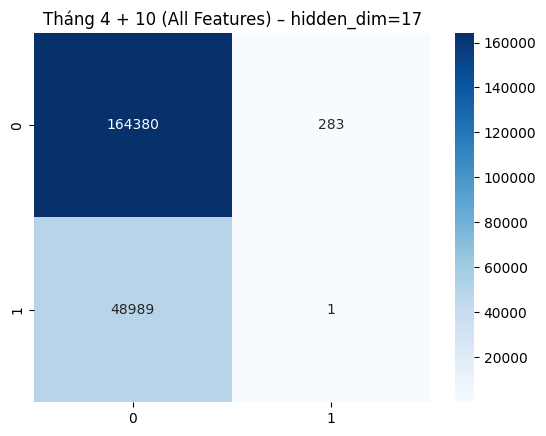


=== Dataset: Tháng 4 + 10 (Top Features) ===
 hidden_dim=10  → val loss = 0.681618
 hidden_dim=20  → val loss = 0.695937
 hidden_dim=50  → val loss = 0.703874
 hidden_dim=100 → val loss = 0.699870
 hidden_dim=150 → val loss = 0.688658
 hidden_dim=17  → val loss = 0.687575
 hidden_dim=25  → val loss = 0.695283
 hidden_dim=34  → val loss = 0.697954
 hidden_dim=50  → val loss = 0.684983
 hidden_dim=68  → val loss = 0.693670
 hidden_dim=85  → val loss = 0.696328
⇒ Best hidden_dim = 10, validation loss = 0.681618
Test classification report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.77      1.00      0.87    164663
           1       0.00      0.00      0.00     48990

    accuracy                           0.77    213653
   macro avg       0.39      0.50      0.44    213653
weighted avg       0.59      0.77      0.67    213653

Test confusion matrix:
 [[164663      0]
 [ 48990      0]]


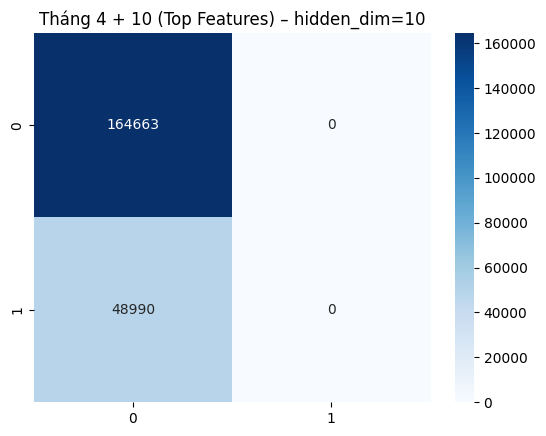

In [15]:
for name, X_trval, y_trval, X_test, y_test in models_info:
    
    train_and_evaluate_model(name + " (All Features)", X_trval, y_trval, X_test, y_test)

    train_and_evaluate_model(name + " (Top Features)", X_trval, y_trval, X_test, y_test, top_features=top_features)

# Oversampling

##  SMOTE

In [16]:
sm = SMOTE()

X_sm, y_sm = sm.fit_resample(X_train, y_train)
X_sm.shape, y_sm.shape

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_sm)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [17]:
models_info = [
    ("Tháng 4 + 10 smote", X_train_scaled, y_sm, X_test_scaled, y_test),
]


=== Dataset: Tháng 4 + 10 smote (All Features) ===
 hidden_dim=10  → val loss = 0.693414
 hidden_dim=20  → val loss = 0.710881
 hidden_dim=50  → val loss = 0.693282
 hidden_dim=100 → val loss = 0.693385
 hidden_dim=150 → val loss = 0.693462
 hidden_dim=17  → val loss = 0.693490
 hidden_dim=25  → val loss = 0.693871
 hidden_dim=34  → val loss = 0.693225
 hidden_dim=50  → val loss = 0.694710
 hidden_dim=68  → val loss = 0.693619
 hidden_dim=85  → val loss = 0.693352
⇒ Best hidden_dim = 34, validation loss = 0.693225


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/tmp/ipykernel_13/2642452818.py:5: RuntimeWarning: invalid value encountered in add
  Z1 = X.dot(W1.T) + b1
/tmp/ipykernel_13/2642452818.py:6: RuntimeWarning: invalid value encountered in tanh
  A1 = np.tanh(Z1)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:14: RuntimeWarning: invalid value encountered in tanh
  dZ1 = dA1 * (1 - np.tanh(Z1)**2)


Test classification report:
              precision    recall  f1-score   support

           0       0.87      0.32      0.46    164663
           1       0.27      0.84      0.41     48990

    accuracy                           0.44    213653
   macro avg       0.57      0.58      0.43    213653
weighted avg       0.73      0.44      0.45    213653

Test confusion matrix:
 [[ 52149 112514]
 [  7913  41077]]


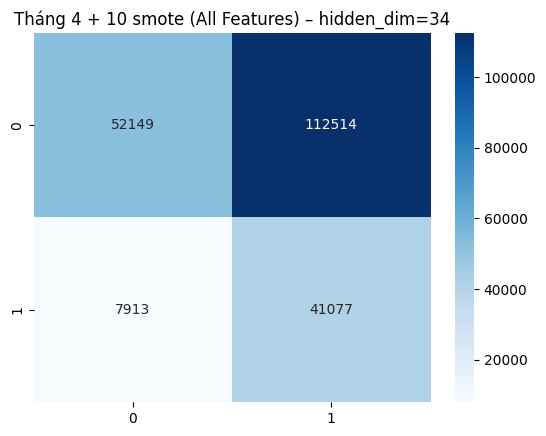


=== Dataset: Tháng 4 + 10 smote (Top Features) ===
 hidden_dim=10  → val loss = 0.693330


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=20  → val loss = 6.574623
 hidden_dim=50  → val loss = 0.693227
 hidden_dim=100 → val loss = 0.693574
 hidden_dim=150 → val loss = 0.694546
 hidden_dim=17  → val loss = 6.570552


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=25  → val loss = 6.572417
 hidden_dim=34  → val loss = 0.811771
 hidden_dim=50  → val loss = 6.570735
 hidden_dim=68  → val loss = 0.693542
 hidden_dim=85  → val loss = 0.693189
⇒ Best hidden_dim = 85, validation loss = 0.693189
Test classification report:
              precision    recall  f1-score   support

           0       0.74      0.83      0.79    164663
           1       0.07      0.04      0.05     48990

    accuracy                           0.65    213653
   macro avg       0.41      0.44      0.42    213653
weighted avg       0.59      0.65      0.62    213653

Test confusion matrix:
 [[137212  27451]
 [ 47067   1923]]


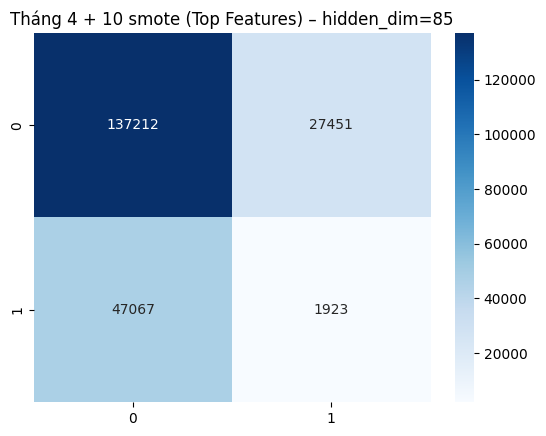

In [18]:
for name, X_trval, y_trval, X_test, y_test in models_info:
    
    train_and_evaluate_model(name + " (All Features)", X_trval, y_trval, X_test, y_test)

    train_and_evaluate_model(name + " (Top Features)", X_trval, y_trval, X_test, y_test, top_features=top_features)

## SMOTE ENN

In [19]:
smenn = SMOTEENN()

X_smenn, y_smenn = smenn.fit_resample(X_train, y_train)
X_smenn.shape, y_sm.shape

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_smenn)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [20]:
models_info = [
    ("Tháng 4 + 10 smote", X_train_scaled, y_smenn, X_test_scaled, y_test),
]


=== Dataset: Tháng 4 + 10 smote (All Features) ===


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/tmp/ipykernel_13/3941530362.py:17: RuntimeWarning: invalid value encountered in multiply
  x_new = x + alpha*d
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))


 hidden_dim=10  → val loss = 14.101383


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=20  → val loss = 6.551915
 hidden_dim=50  → val loss = 0.693408


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=100 → val loss = 6.534290
 hidden_dim=150 → val loss = 6.528464
 hidden_dim=17  → val loss = 0.693326
 hidden_dim=25  → val loss = 0.694604


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=34  → val loss = 21.083831
 hidden_dim=50  → val loss = 0.693531
 hidden_dim=68  → val loss = 0.692955
 hidden_dim=85  → val loss = 0.693487
⇒ Best hidden_dim = 68, validation loss = 0.692955
Test classification report:
              precision    recall  f1-score   support

           0       0.82      0.34      0.49    164663
           1       0.25      0.75      0.38     48990

    accuracy                           0.44    213653
   macro avg       0.54      0.55      0.43    213653
weighted avg       0.69      0.44      0.46    213653

Test confusion matrix:
 [[ 56669 107994]
 [ 12106  36884]]


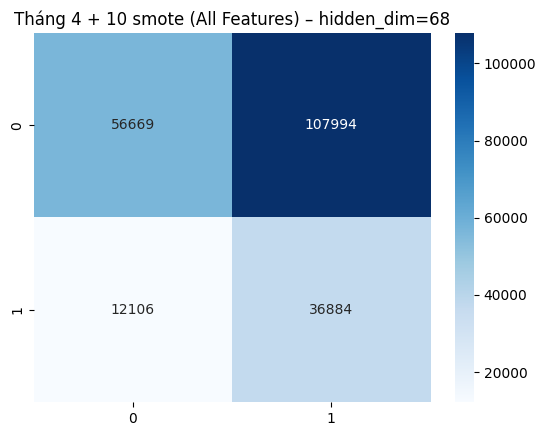


=== Dataset: Tháng 4 + 10 smote (Top Features) ===
 hidden_dim=10  → val loss = 5.686243
 hidden_dim=20  → val loss = 0.693716
 hidden_dim=50  → val loss = 5.688324
 hidden_dim=100 → val loss = 0.693661
 hidden_dim=150 → val loss = 5.687075


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in tanh
  result = func(self.values, **kwargs)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * n

 hidden_dim=17  → val loss = 5.700582
 hidden_dim=25  → val loss = 0.693607
 hidden_dim=34  → val loss = 0.693692
 hidden_dim=50  → val loss = 0.693976
 hidden_dim=68  → val loss = 13.632194
 hidden_dim=85  → val loss = 0.694253
⇒ Best hidden_dim = 25, validation loss = 0.693607


/tmp/ipykernel_13/3941530362.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = -d.dot(g) / (delta + lambd*mu)
/tmp/ipykernel_13/2642452818.py:5: RuntimeWarning: invalid value encountered in add
  Z1 = X.dot(W1.T) + b1
/tmp/ipykernel_13/2642452818.py:6: RuntimeWarning: invalid value encountered in tanh
  A1 = np.tanh(Z1)
/tmp/ipykernel_13/2642452818.py:9: RuntimeWarning: invalid value encountered in log
  loss = -np.mean(np.sum(Y_oh * np.log(A2 + 1e-12), axis=1))
/tmp/ipykernel_13/2642452818.py:14: RuntimeWarning: invalid value encountered in tanh
  dZ1 = dA1 * (1 - np.tanh(Z1)**2)


Test classification report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    164663
           1       0.23      1.00      0.37     48990

    accuracy                           0.23    213653
   macro avg       0.11      0.50      0.19    213653
weighted avg       0.05      0.23      0.09    213653

Test confusion matrix:
 [[     0 164663]
 [     0  48990]]


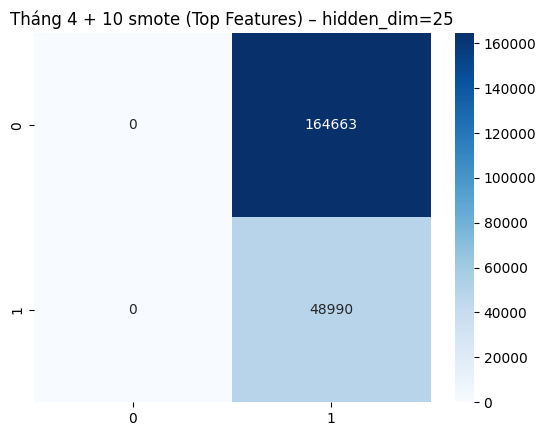

In [21]:
for name, X_trval, y_trval, X_test, y_test in models_info:
    
    train_and_evaluate_model(name + " (All Features)", X_trval, y_trval, X_test, y_test)

    train_and_evaluate_model(name + " (Top Features)", X_trval, y_trval, X_test, y_test, top_features=top_features)

# 7. Kết luận

Mô hình SVG ban đầu (không SMOTE hay SMOTE ENN) là tốt nhất.